In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pathlib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import glob
from torch.autograd import Variable
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

In [162]:
transformer = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(), # 0-255 to 0-1 numpy to tensor
]) 

In [163]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [164]:
print(device)

cuda


In [165]:
# paths to dataset

train_path = r'D:\Main Current PC\Book\train'
test_path = r'D:\Main Current PC\Book\test'

In [166]:
# feed the data in the form of Data Loader to the model
train_loader = DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform=transformer),
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    torchvision.datasets.ImageFolder(test_path, transform=transformer),
    batch_size=32,
    shuffle=True
)

In [167]:
def get_categories(path):
    """
    Input: Path
    Output: List of Categories
    """
    
    root = pathlib.Path(path)
    classes = list()
    for category in root.iterdir():
        classes.append(str(category).split('\\')[-1])
    
    return classes

In [168]:
categories = get_categories(train_path)
print(categories)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [169]:
# # CNN Network
# class Net(nn.Module):
    
#     def __init__(self, num_categories=7):
#         super(Net, self).__init__()
        
#         # layer 1
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1)
#         self.relu1 = nn.ReLU()
#         # reduction by factor of 2 in dimensions
#         # TODO: find out about other sizes and strides
#         self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
#         # layer 2
#         self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, padding=1)
#         self.relu2 = nn.ReLU()
#         self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
#         self.dropout1 = nn.Dropout2d(p = 0.35)
        
#         # layer 3
#         self.conv3 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, padding=1)
#         self.relu3 = nn.ReLU()
        
#         # layer 4
#         self.conv4 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, padding=1)
#         self.relu4 = nn.ReLU()
        
#         # 48 -> 24 -> 12
#         # 32 channels x (12 x 12) image dimensions
#         # 32 x 12 x 12
        
#         self.fc1 = nn.Linear(32 * 12 * 12, 1000)
#         self.relufc1 = nn.ReLU()
        
#         self.fc2 = nn.Linear(1000, 80)
#         self.relufc2 = nn.ReLU()
        
#         self.fc3 = nn.Linear(80, num_categories)
        
#     def forward(self, X):
        
#         X = self.conv1(X)
#         X = self.relu1(X)
#         X = self.maxpool1(X)
        
#         X = self.conv2(X)
#         X = self.relu2(X)
#         X = self.maxpool2(X)
#         X = self.dropout1(X)
        
#         X = self.conv3(X)
#         X = self.relu3(X)
        
#         X = self.conv4(X)
#         X = self.relu4(X)
        
#         X = torch.flatten(X, 1)
        
#         X = self.fc1(X)
#         X = self.relufc1(X)
        
#         X = self.fc2(X)
#         X = self.relufc2(X)
        
#         output = self.fc3(X)
        
#         return output

In [170]:
# CNN Network
class Net(nn.Module):
    
    def __init__(self, num_categories=7):
        super(Net, self).__init__()
        
        # layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        # reduction by factor of 2 in dimensions
        # TODO: find out about other sizes and strides
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        # layer 2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        # layer 3
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=18, kernel_size=5, padding=2)
        self.relu3 = nn.ReLU()
        
        # layer 4
#         self.conv4 = nn.Conv2d(in_channels=18, out_channels=36, kernel_size=3, padding=1)
#         self.relu4 = nn.ReLU()
        
        # 48 -> 24 -> 12
        # 32 channels x (12 x 12) image dimensions
        # 32 x 12 x 12
        
        self.fc1 = nn.Linear(18 * 12 * 12, 120)
        self.dropout1 = nn.Dropout2d(p = 0.05)

        self.relufc1 = nn.ReLU()
        
        self.fc2 = nn.Linear(120, 80)
#         self.dropout2 = nn.Dropout2d(p = 0.40)
        self.relufc2 = nn.ReLU()
        
        self.fc3 = nn.Linear(80, num_categories)
        
    def forward(self, X):
        
        X = self.conv1(X)
        X = self.relu1(X)
        X = self.maxpool1(X)
        
        X = self.conv2(X)
        X = self.relu2(X)
        X = self.maxpool2(X)
        
        X = self.conv3(X)
        X = self.relu3(X)
        
#         X = self.conv4(X)
#         X = self.relu4(X)
        
        X = torch.flatten(X, 1)
        
        X = self.fc1(X)
        X = self.dropout1(X)
        X = self.relufc1(X)
        
        X = self.fc2(X)
#         X = self.dropout2(X)
        X = self.relufc2(X)
        
        output = self.fc3(X)
        
        return output

In [171]:
model = Net(num_categories=7).to(device)

In [172]:
model

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(12, 18, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu3): ReLU()
  (fc1): Linear(in_features=2592, out_features=120, bias=True)
  (dropout1): Dropout2d(p=0.05, inplace=False)
  (relufc1): ReLU()
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (relufc2): ReLU()
  (fc3): Linear(in_features=80, out_features=7, bias=True)
)

In [176]:
optimizer = Adam(params=model.parameters(), lr=0.0021, weight_decay=0.0001)
loss_function =  nn.CrossEntropyLoss()
num_epochs = 20

In [177]:
# calculating size of train and test dataset
train_count = len(glob.glob(train_path+'/**/*.png'))
test_count = len(glob.glob(test_path+'/**/*.png'))

In [179]:
train_count

28709

In [180]:
best_accuracy = 0.0
test_accuracy_list = list()
train_accuracy_list = list()
training_loss = list()

for epoch in range(num_epochs):
    
    # Evaluation and training on training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0
    
    for i, (images, labels) in enumerate(train_loader):
        
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        
        # to avoid gradient accumulation. VERY IMPORTANT
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        
        # update the weights and biases
        optimizer.step()
        
        train_loss += loss.cpu().data*images.size(0)
        _, prediction = torch.max(outputs.data, 1) 
        
        train_accuracy += int(torch.sum(prediction==labels.data))
    
    train_accuracy /= train_count
    train_accuracy_list.append(train_accuracy)
    
    train_loss /= train_count
    training_loss.append(train_loss)
    test_accuracy = 0.0
    
    # Evaluation on testing dataset
    model.eval()
    for i, (images, labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1) 
        test_accuracy += int(torch.sum(prediction==labels.data))
        
    test_accuracy /= test_count
    
    print(f"""
    Epoch : {epoch}, Train Loss : {train_loss}, Train Accuracy : {train_accuracy}, Test Accuracy : {test_accuracy}
    """)
    
    test_accuracy_list.append(test_accuracy)
    # Save best model
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint.model')
        best_accuracy = test_accuracy


    Epoch : 0, Train Loss : 1.781368374824524, Train Accuracy : 0.26225225539029573, Test Accuracy : 0.34313179158539986
    

    Epoch : 1, Train Loss : 1.5824745893478394, Train Accuracy : 0.3798808735936466, Test Accuracy : 0.4001114516578434
    

    Epoch : 2, Train Loss : 1.468206524848938, Train Accuracy : 0.4289595597199484, Test Accuracy : 0.441209250487601
    

    Epoch : 3, Train Loss : 1.386243462562561, Train Accuracy : 0.46306036434567555, Test Accuracy : 0.45611590972415716
    

    Epoch : 4, Train Loss : 1.3267706632614136, Train Accuracy : 0.4908565258281375, Test Accuracy : 0.4632209529116746
    

    Epoch : 5, Train Loss : 1.2685714960098267, Train Accuracy : 0.5102581072137657, Test Accuracy : 0.48161047645583727
    

    Epoch : 6, Train Loss : 1.2199358940124512, Train Accuracy : 0.5323069420739142, Test Accuracy : 0.47130119810532184
    

    Epoch : 7, Train Loss : 1.1643739938735962, Train Accuracy : 0.5552614162806089, Test Accuracy : 0.476734466425

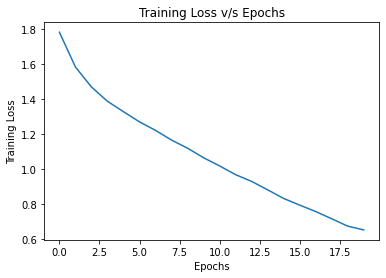

In [181]:
epochs = list(range(20))
plt.title('Training Loss v/s Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.plot(epochs, training_loss)

In [225]:
test_accuracy_list

[0.49456673168013376,
 0.5016717748676511,
 0.48021733073279466,
 0.49052660908331014,
 0.4927556422401783,
 0.48843689049874617,
 0.4887155196433547,
 0.4896907216494845,
 0.4917804402340485,
 0.4928949568124826]

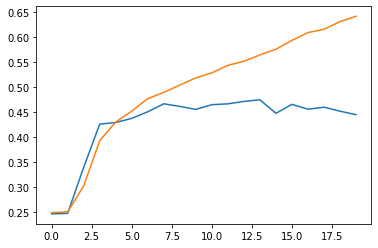

In [132]:
plt.plot(epochs, test_accuracy_list)
plt.plot(epochs, train_accuracy_list)
plt.show()

In [183]:
outputs

tensor([[ 4.5217, -5.6837,  1.9399, -0.9727, -3.7017, -0.8737, -1.6833],
        [-1.3481, -4.8862,  2.1244, -1.6541,  0.1664, -0.8722,  1.1336],
        [-2.1595, -8.7955, -1.1004, -1.0721,  3.3069,  3.0836, -4.9792],
        [-3.4131, -7.4820,  0.3867,  1.3416,  2.0476, -1.6008, -1.4037],
        [-0.5400, -9.9877,  1.1077, -0.0416,  2.3823,  1.9268, -4.4857],
        [-5.8934, -7.1273, -2.6109,  7.4993, -1.3908, -2.3973, -1.2556],
        [ 1.0475, -1.7575,  0.0709, -1.0906,  0.1202,  1.0979, -3.3851],
        [-0.1660, -5.3451,  0.0376,  1.8406, -0.6616, -1.4944, -0.6469],
        [ 0.2452, -3.8146,  1.2657, -7.1774, -2.9250, -1.6596,  5.1843],
        [-1.3308, -1.6945, -0.4389,  0.8936, -0.0191,  1.0585, -2.7444]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [82]:
model_load = Net()
model_load.load_state_dict(torch.load('best_checkpoint.model'))

<All keys matched successfully>

In [83]:
model_load.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (fc1): Linear(in_features=4608, out_features=1000, bias=True)
  (relufc1): ReLU()
  (fc2): Linear(in_features=1000, out_features=80, bias=True)
  (relufc2): ReLU()
  (fc3): Linear(in_features=80, out_features=7, bias=True)
)

In [85]:
sample_path = 'D:\Main Current PC\Book\sample'

In [105]:
categories

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [106]:
sample_loader = DataLoader(
    torchvision.datasets.ImageFolder(sample_path, transform=transformer),
    batch_size=1,
    shuffle=True
)

In [107]:
transformer = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(), # 0-255 to 0-1 numpy to tensor
]) 

In [108]:
for i, (images, labels) in enumerate(sample_loader):
        if torch.cuda.is_available():
            images = Variable(images)
            labexls = Variable(labels)
        
        outputs = model_load(images)
        _, prediction = torch.max(outputs.data, 1) 
        test_accuracy += int(torch.sum(prediction==labels.data))
    

In [109]:
prediction

tensor([3])

In [110]:
def predict_image(image):
    image_tensor = transformer(image).float()
    image_tensor = imagetensor.unsqueeze(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model_load(input)
    index = output.data.cpu().numpy().argmax()
    return index